In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

In [10]:
warnings.filterwarnings("ignore")

In [11]:
df_LR = pd.read_csv('/content/drive/MyDrive/Major Project/Exoplanets/Data/LR_Data.csv')
df_NB = pd.read_csv('/content/drive/MyDrive/Major Project/Exoplanets/Data/NB_Data.csv')
df_RF = pd.read_csv('/content/drive/MyDrive/Major Project/Exoplanets/Data/RF_Data.csv')
df_DT = pd.read_csv('/content/drive/MyDrive/Major Project/Exoplanets/Data/DT_Data.csv')

In [12]:
class predictiveModelling:
    def __init__(self, df):
        self.df = df
        self.X = None
        self.y = None
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
    
    def LR_Classifier(self):
        print("\nTraining the Logistic Regression model...\n")
        LRClassifier = LogisticRegression()
        LRClassifier.fit(self.X_train , self.y_train)
        pickle.dump(LRClassifier, open('/content/drive/MyDrive/Major Project/Exoplanets/Model/LR_model.sav', 'wb'))
        self.displayConfusionMatrix(LRClassifier)

    def NB_Classifier(self):
        print("\nTraining the Gaussian Naive Bayes model...\n")
        NBClassifier = GaussianNB()
        NBClassifier.fit(self.X_train , self.y_train)
        self.displayConfusionMatrix(NBClassifier)
    
    def RF_Classifier(self):  
        print("\nTraining the Random Forest model...\n")      
        RFClassifier = RandomForestClassifier(n_estimators = 50, criterion = 'gini',random_state = 41)
        RFClassifier.fit(self.X_train , self.y_train)
        self.displayConfusionMatrix(RFClassifier)

    def DT_Classifier(self):
        print("\nTraining the Decision Tree model...\n")
        DFClassifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 41)
        DFClassifier.fit(self.X_train , self.y_train)
        self.displayConfusionMatrix(DFClassifier)

    def XG_boost(self):
        XGBclassifier = XGBClassifier()
        XGBclassifier.fit(self.X_train, self.y_train)
        self.displayConfusionMatrix(XGBclassifier)

    def prepareDF(self):
        self.X = self.df.iloc[: ,:-1].values
        self.y = self.df.iloc[: ,-1].values
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X,self.y,test_size = 0.25 ,random_state = 41)
        sc = StandardScaler()
        self.X_train = sc.fit_transform(self.X_train)
        self.X_test = sc.transform(self.X_test)

    def displayConfusionMatrix(self, classifier):
        print("\nComputing Model results...\n")
        y_pred = classifier.predict(self.X_test)
        cm = confusion_matrix(self.y_test, y_pred)
        print("Accuracy Score : ",accuracy_score(self.y_test, y_pred), "\n")
        print(classification_report(self.y_test, y_pred, target_names=['CANDIDATE', 'FALSE POSITIVE']), "\n")
        sns.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
        plt.show()
        self.verifyModel(classifier)

    def verifyModel(self, model):
        n_splits = 20
        print("\nPerforming " + str(n_splits) + " fold cross validation....\n")
        kf = KFold(n_splits=n_splits)
        mae_train = []
        mae_test = []
        kFoldClassifiers = []

        for train_index, test_index in kf.split(self.X):
            X_train, X_test = self.df.iloc[: ,:-1].iloc[train_index], self.df.iloc[: ,:-1].iloc[test_index]
            y_train, y_test = self.y[train_index], self.y[test_index]

            model.fit(X_train , y_train)
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            mae_train.append(mean_absolute_error(y_train, y_train_pred))
            mae_test.append(mean_absolute_error(y_test, y_test_pred))

        folds = range(1, kf.get_n_splits() + 1)
        plt.plot(folds, mae_train, 'o-', color='green', label='train')
        plt.plot(folds, mae_test, 'o-', color='red', label='test')
        plt.legend()
        plt.grid()
        plt.xlabel('Number of folds')
        plt.ylabel('Mean Absolute Error')
        plt.show()
        self.ROC_Curve(model)

    def ROC_Curve(self, model):
        print("Plotting ROC curve...\n")
        ns_probs = [0 for _ in range(len(self.y_test))]
        model_probs = model.predict_proba(self.X_test)
        model_probs = model_probs[:, 1]
        ns_auc = roc_auc_score(self.y_test, ns_probs)
        model_auc = roc_auc_score(self.y_test, model_probs)
        print('No Skill: ROC AUC=%.3f' % (ns_auc))
        print('Model: ROC AUC=%.3f' % (model_auc))
        ns_fpr, ns_tpr, _ = roc_curve(self.y_test, ns_probs)
        model_fpr, model_tpr, _ = roc_curve(self.y_test, model_probs)
        pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        pyplot.plot(model_fpr, model_tpr, marker='.', label='Logistic')
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        pyplot.legend()
        pyplot.show()


Training the Logistic Regression model...


Computing Model results...

Accuracy Score :  0.9870347135089921 

                precision    recall  f1-score   support

     CANDIDATE       0.98      0.99      0.99      1143
FALSE POSITIVE       0.99      0.98      0.99      1248

      accuracy                           0.99      2391
     macro avg       0.99      0.99      0.99      2391
  weighted avg       0.99      0.99      0.99      2391
 



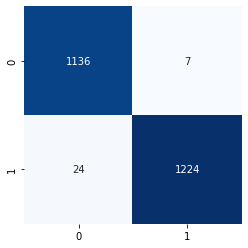


Performing 20 fold cross validation....



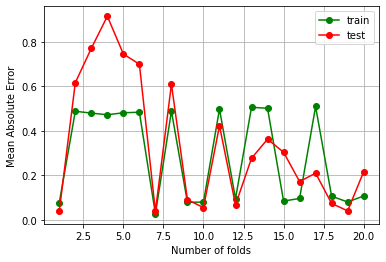

Plotting ROC curve...

No Skill: ROC AUC=0.500
Model: ROC AUC=0.978


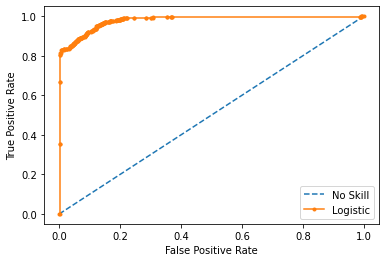

In [13]:
pm = predictiveModelling(df_LR)
pm.prepareDF()
pm.LR_Classifier()


Training the Gaussian Naive Bayes model...


Computing Model results...

Accuracy Score :  0.9849435382685069 

                precision    recall  f1-score   support

     CANDIDATE       0.98      0.99      0.98      1143
FALSE POSITIVE       0.99      0.98      0.99      1248

      accuracy                           0.98      2391
     macro avg       0.98      0.99      0.98      2391
  weighted avg       0.98      0.98      0.98      2391
 



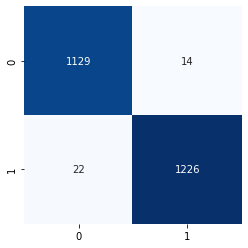


Performing 20 fold cross validation....



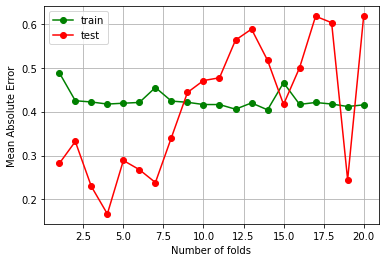

Plotting ROC curve...

No Skill: ROC AUC=0.500
Model: ROC AUC=0.857


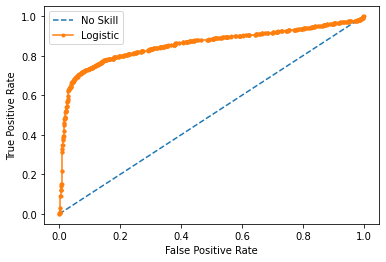

In [14]:
pm = predictiveModelling(df_NB)
pm.prepareDF()
pm.NB_Classifier()


Training the Random Forest model...


Computing Model results...

Accuracy Score :  0.9899623588456713 

                precision    recall  f1-score   support

     CANDIDATE       0.98      1.00      0.99      1143
FALSE POSITIVE       1.00      0.98      0.99      1248

      accuracy                           0.99      2391
     macro avg       0.99      0.99      0.99      2391
  weighted avg       0.99      0.99      0.99      2391
 



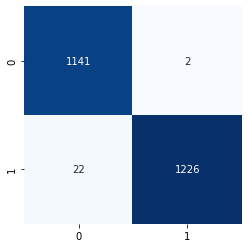


Performing 20 fold cross validation....



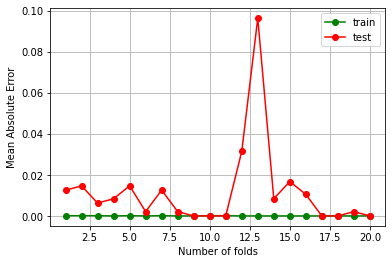

Plotting ROC curve...

No Skill: ROC AUC=0.500
Model: ROC AUC=0.992


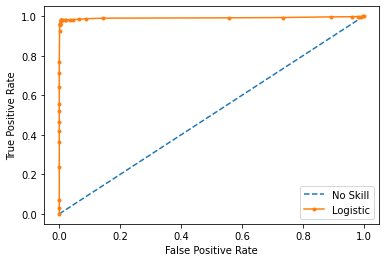

In [15]:
pm = predictiveModelling(df_RF)
pm.prepareDF()
pm.RF_Classifier()


Training the Decision Tree model...


Computing Model results...

Accuracy Score :  0.9824341279799247 

                precision    recall  f1-score   support

     CANDIDATE       0.98      0.98      0.98      1143
FALSE POSITIVE       0.98      0.98      0.98      1248

      accuracy                           0.98      2391
     macro avg       0.98      0.98      0.98      2391
  weighted avg       0.98      0.98      0.98      2391
 



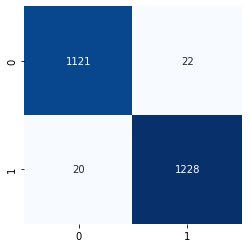


Performing 20 fold cross validation....



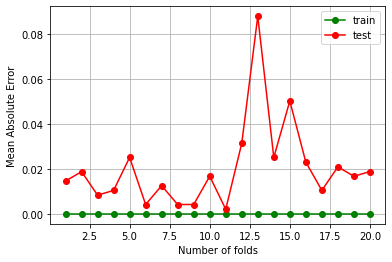

Plotting ROC curve...

No Skill: ROC AUC=0.500
Model: ROC AUC=0.942


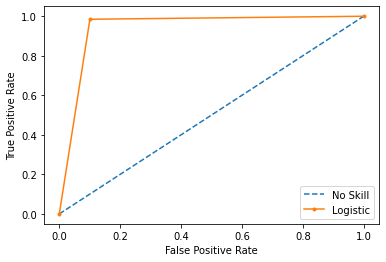

In [16]:
pm = predictiveModelling(df_DT)
pm.prepareDF()
pm.DT_Classifier()


Computing Model results...

Accuracy Score :  0.9891258887494772 

                precision    recall  f1-score   support

     CANDIDATE       0.98      1.00      0.99      1143
FALSE POSITIVE       1.00      0.98      0.99      1248

      accuracy                           0.99      2391
     macro avg       0.99      0.99      0.99      2391
  weighted avg       0.99      0.99      0.99      2391
 



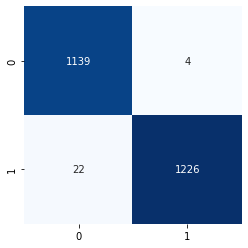


Performing 20 fold cross validation....



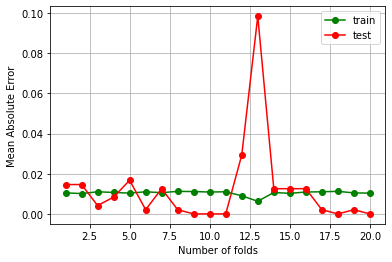

Plotting ROC curve...



ValueError: ignored

In [17]:
pm = predictiveModelling(df_RF)
pm.prepareDF()
pm.XG_boost()